# Text Classification  SKB Graph on Ohsumed via Attention
* By Xiaoran Li (Shizuoka Institute of Science and Technology) for JSAI2022
---

In [318]:
import nltk
import numpy as np
import re
import glob
import os
import tqdm
import sys
import json
import spacy
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from scipy import linalg, mat, dot, stats
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

dataset = "ohsumed"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adaptsystemlab2019/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [85]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"patients ", "", string)
    return string.strip().lower()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
def lemmatization(sentence):
    tokens = word_tokenize(sentence)
    tagged_sent = pos_tag(tokens)
    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append((wnl.lemmatize(tag[0], pos = wordnet_pos),wordnet_pos))
    return lemmas_sent

def lemmatization_original(sentence):
    tokens = word_tokenize(sentence)
    tagged_sent = pos_tag(tokens)
    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos = wordnet_pos))
    return lemmas_sent

def getPos(sentence):
    tokens = word_tokenize(sentence)
    tagged_sent = pos_tag(tokens)
    sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        sent.append((tag[0], wordnet_pos))
    return sent

def countMinMaxAver(lines):
    min_len = 10000
    aver_len = 0
    max_len = 0
    for temp in lines:
        aver_len = aver_len + len(temp)
        if len(temp) < min_len:
            min_len = len(temp)
        if len(temp) > max_len:
            max_len = len(temp)
    aver_len = 1.0 * aver_len / len(lines)
    print('min_len : ' + str(min_len))
    print('max_len : ' + str(max_len))
    print('average_len : ' + str(aver_len))

## remove stop words

In [86]:
def _getTextFile(langual):
    file_list = glob.glob(f'../data/stopwords/stopwords/*_{langual}.txt')
    files = ",".join(file_list)
    return files
def cleanText(english_txt):
    try:
        word_tokens = english_txt.split()
        filtered_word = [w for w in word_tokens if w not in stop_words and not w.isdigit()]
        filtered_word = [w + " " for w in filtered_word]
        return "".join(filtered_word)
    except:
        return np.nan
def cleanNonEnglish(txt):
    txt = clean_str(txt)
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = txt.split()
    filtered_word = [w for w in word_tokens if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)


In [87]:
stop_words = set()
for file in _getTextFile("en").split(","):
    for word in open(file):
        stop_words.add(word.strip())
doc_content_list = []
f = open('../data/corpus/' + dataset + '.txt', 'rb')
for line in f.readlines():
    doc_content_list.append(line.strip().decode('latin1'))
f.close()
countMinMaxAver([item.split() for item in doc_content_list])

min_len : 28
max_len : 596
average_len : 186.03851351351352


## lemmatization

In [88]:
doc_content_list[0]

'Infection in total joint replacement.  Although a small number of infections in total joint replacements are blood borne from distant sources, most infections appear to have been derived at operation.  Strenuous attempts to reduce this risk by cleaning the air in the wound environment, coupled with prophylactic antibiotics, have reduced infection rates by an order of magnitude in a decade.  During that time the potential for exchange arthroplasty in established infection has been shown, and the results are encouraging.  Rigorous infection control is the key to containing this difficult and expensive problem.'

In [89]:
doc_content_list = [cleanText(cleanNonEnglish(sentence).strip()).strip() for sentence in doc_content_list]
doc_content_lemmatization_list = [" ".join(lemmatization_original(sentence)) for sentence in doc_content_list]

In [90]:
doc_content_list[0]

'infection total joint replacement small number infections total joint replacements blood borne distant sources infections derived operation strenuous attempts reduce risk cleaning air wound environment coupled prophylactic antibiotics reduced infection rates order magnitude decade time potential exchange arthroplasty established infection encouraging rigorous infection control key difficult expensive problem'

In [91]:
len(doc_content_list[0].split())==len(doc_content_lemmatization_list[0].split())

True

## Analysis for OOV on dataset

In [122]:
def wordFreq(docs):
    word_freq = {}
    for doc in docs:
        for word in doc.split():
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq
def evaluationFrequncy(docs,save_name):
    '''evaluation frequncy for document lexions'''
    word_freq = wordFreq(docs)
    print("#all word size: ", len(word_freq))
    word_freq_sorted = sorted(word_freq.items(), key = lambda kv:(kv[1], kv[0]))
    print("#frequncy mean: ", np.mean(list(word_freq.values())))
    print("#frequncy standard deviation: ", np.std(list(word_freq.values())))
    print("#frequncy std/mean: ", np.std(list(word_freq.values()))/np.mean(list(word_freq.values())))
    axes = sns.scatterplot(data=list(word_freq.values())).set_title(save_name)
    axes.figure.set_size_inches(18,4)
    fig = axes.get_figure()
    fig.savefig("../data/images/"+save_name+".png", dpi = 400)
    return word_freq, word_freq_sorted

#all word size:  31963
#frequncy mean:  22.502362106185277
#frequncy standard deviation:  96.59746181770852
#frequncy std/mean:  4.29276985953206
#all word size:  28897
#frequncy mean:  24.8898847631242
#frequncy standard deviation:  122.58557512115955
#frequncy std/mean:  4.925116218407614


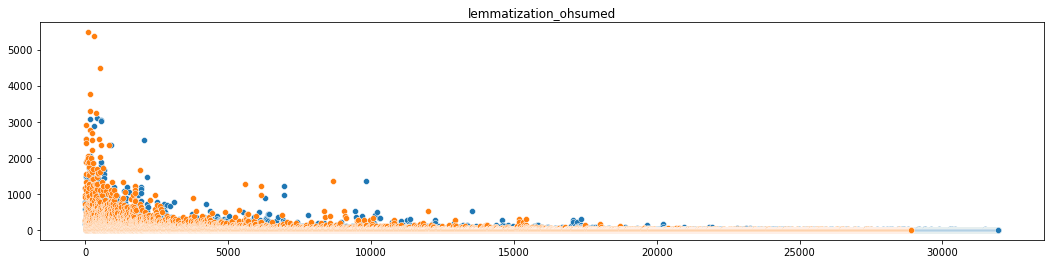

In [141]:
raw_word_freq, raw_word_freq_sorted = evaluationFrequncy(doc_content_list,"raw_ohsumed")
lemm_word_freq, lemm_word_freq_sorted = evaluationFrequncy(doc_content_lemmatization_list,"lemmatization_ohsumed")

In [94]:
doc_content_tuple = (raw_word_freq,raw_word_freq_sorted,doc_content_list)
doc_content_lemmatization_tuple = (lemm_word_freq,lemm_word_freq_sorted,doc_content_lemmatization_list)

In [95]:
np.save("../data/corpus/" + dataset+".clean", doc_content_tuple)
np.save("../data/corpus/" + dataset+".clean.lemmatization", doc_content_lemmatization_tuple)

/home/adaptsystemlab2019/yes/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Get the DictSKB and own SKB-DA

In [266]:
doc_content_lemmatization_tuple: tuple = np.load("../data/corpus/" + dataset+".clean.lemmatization.npy",\
                                                 allow_pickle=True).tolist()
doc_content_tuple: tuple = np.load("../data/corpus/" + dataset+".clean.npy", allow_pickle=True).tolist()
dictskb = np.load("../sememe_dataset/DictSKB_dict.npy", allow_pickle=True).tolist()
dictskb_cdv = np.load("../sememe_dataset/DictSKB_sememes.npy", allow_pickle=True).tolist()
skb_da = np.load("../sememe_dataset/skb_ad_dict.npy", allow_pickle=True).tolist()
networkskb = np.load("../sememe_dataset/sememe_network_dict_en_wordnet_5000.npy", allow_pickle=True).tolist()
networkskb_cdv = np.load("../sememe_dataset/sememe_network_cdv_en_wordnet_5000.npy", allow_pickle=True).tolist()

In [267]:
def removeWikiSenseOnSKBDA(skb_da_dict):
    '''uniform for SKB-DA sense'''
    skb_da_pure_dict = {}
    skb_da_cdv_set = set()
    for word, sense in tqdm.tqdm(skb_da_dict.items()):
        for (pos, sememe_set) in sense:
            if " (" in word:
                if len(word.split(" (")) == 3:
                    word, sense1,sense2 = word.split(" (")
                    sense1 = sense1.replace(")","")
                    sense2 = sense2.replace(")","")
                    if word not in skb_da_pure_dict.keys():
                        skb_da_pure_dict[word] = []
                    #sememe_set.add(sense1)
                    #sememe_set.add(sense2)
                    sememe_set.discard(word)
                    skb_da_pure_dict[word].append((sense1+" - "+sense2,sememe_set))
                    skb_da_cdv_set =  skb_da_cdv_set | sememe_set
                    continue
                word, sense = word.split(" (")
                sense = sense.replace(")","")
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                #sememe_set.add(sense)
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((sense,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
            else:
                if word not in skb_da_pure_dict.keys():
                    skb_da_pure_dict[word] = []
                sememe_set.discard(word)
                skb_da_pure_dict[word].append((pos,sememe_set))
                skb_da_cdv_set =  skb_da_cdv_set | sememe_set
    print("#all lexicon of SKB-DA: {}; #CDV of SKB-DA: {}".format(len(skb_da_pure_dict),len(skb_da_cdv_set)))
    return skb_da_pure_dict,skb_da_cdv_set

In [268]:
skb_da_pure,skb_da_pure_cdv_set = removeWikiSenseOnSKBDA(skb_da)

100%|█████████████████████████████████| 910369/910369 [01:35<00:00, 9573.96it/s]

#all lexicon of SKB-DA: 800795; #CDV of SKB-DA: 5000


In [269]:
def _networkskbForm(networkskb):
    '''uniform for NetWorkSKB'''
    networkskb_form = {}
    for wn_k,wn_v in networkskb.items():
        word = wn_k.split(".")[0]
        if word not in networkskb_form.keys():
            networkskb_form[word] = []
        networkskb_form[word].append((wn_k.split(".")[1],wn_v))
    return networkskb_form

In [270]:
networkskb = _networkskbForm(networkskb)

### How many words of  doc_content are in the lexicons of SKB-DA
>* doc_content_lemmatization SKB-DA
>* doc_content DictSKB
>* doc_content_lemmatization DictSKB

In [271]:
def checkExistFreq(doc_tuple,skb_dict,label_name_str):
    '''How many words of doc_content are in the lexicons of SKB-DA'''
    exist_freq = wordFreq([" ".join([word for word in sentence.split() if word in skb_dict.keys()])\
                          for sentence in doc_tuple[2]])
    #exist_freq_df = pd.DataFrame({label_name_str: list(exist_freq.values())})
    #axes = sns.scatterplot(data = exist_freq_df)
    #axes.figure.set_size_inches(18,4)
    #fig = axes.get_figure()
    #fig.savefig("../data/images/"+doc_content_tuple+".exist_freq.png", dpi = 400)
    print(len(exist_freq)/len(doc_tuple[1]))
    return len(exist_freq)/len(doc_tuple[1])

In [272]:
_ = checkExistFreq(doc_content_lemmatization_tuple,skb_da_pure,"lemmatization on DictSKB(Pure)")
_ = checkExistFreq(doc_content_tuple,skb_da_pure,"raw on DictSKB(Pure)")
_ = checkExistFreq(doc_content_lemmatization_tuple,skb_ad,"lemmatization on SKB_DA")
_ = checkExistFreq(doc_content_tuple,skb_ad,"raw on SKB_DA")
_ = checkExistFreq(doc_content_lemmatization_tuple,networkskb,"lemmatization on NetWorkSKB")
_ = checkExistFreq(doc_content_tuple,networkskb,"raw on NetWorkSKB")
_ = checkExistFreq(doc_content_lemmatization_tuple,dictskb,"lemmatization on DictSKB")
_ = checkExistFreq(doc_content_tuple,dictskb,"raw on DictSKB")

0.5473578572170121
0.5086193411131621
0.5129944284873862
0.4680411726058255
0.4210125618576323
0.3761536776898289
0.30664082776758833
0.26471232362419045


## the evaluation for embeddings of lexicon 

In [259]:
def loadGloveModel(gloveFile):
    '''Loading Glove Model'''
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in tqdm.tqdm(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [214]:
glove_6B_300d_wiki = loadGloveModel("../data/embeddings/glove.6B.300d.wiki.txt")

Loading Glove Model


400001it [00:13, 29576.70it/s]

Done. 400001  words loaded!


In [262]:
glove_twitter_27B_200d_txt = loadGloveModel("../data/embeddings/glove.twitter.27B.200d.txt")

1193517it [00:28, 42039.70it/s]

Done. 1193515  words loaded!


In [260]:
glove_840B_300d_common_crawl = loadGloveModel("../data/embeddings/glove.840B.300d.common_crawl.txt")

2196018it [01:13, 29914.97it/s]

Done. 2196017  words loaded!


In [277]:
def checkEmbeddingsLexicon(doc_content_tuple, skb_dict, skb_cdv, embedding_dict):
    '''check the number of embedding in doc and skb'''
    embeddings_in_doc = len(set(doc_content_tuple[0].keys()) & set(embedding_dict.keys()))/\
                        len(set(doc_content_tuple[0].keys()))
    embeddings_in_skb_key = len(set(skb_dict.keys()) & set(embedding_dict.keys()))/\
                            len(set(skb_dict.keys()))
    embeddings_in_skb_sememe = len(skb_cdv & set(embedding_dict.keys()))/\
                               len(skb_cdv)
    print("The Embedding Lexion in doc: {}; in SKB keys: {}; in SKB Sememes: {}"\
          .format(embeddings_in_doc,embeddings_in_skb_key,embeddings_in_skb_sememe))
    return embeddings_in_doc,embeddings_in_skb_key,embeddings_in_skb_sememe

In [278]:
_,_,_ = checkEmbeddingsLexicon(doc_content_lemmatization_tuple,skb_da_pure,skb_da_pure_cdv_set,\
                               glove_twitter_27B_200d_txt)
_,_,_ = checkEmbeddingsLexicon(doc_content_tuple,skb_da_pure,skb_da_pure_cdv_set,glove_twitter_27B_200d_txt)

The Embedding Lexion in doc: 0.4780427033948161; in SKB keys: 0.12749455228866313; in SKB Sememes: 0.8496
The Embedding Lexion in doc: 0.5076181835247005; in SKB keys: 0.12749455228866313; in SKB Sememes: 0.8496


In [279]:
_,_,_ = checkEmbeddingsLexicon(doc_content_lemmatization_tuple,skb_da_pure,skb_da_pure_cdv_set,glove_6B_300d_wiki)
_,_,_ = checkEmbeddingsLexicon(doc_content_tuple,skb_da_pure,skb_da_pure_cdv_set,glove_6B_300d_wiki)

The Embedding Lexion in doc: 0.6542547669308233; in SKB keys: 0.18834782934458882; in SKB Sememes: 0.8918
The Embedding Lexion in doc: 0.6828207615054908; in SKB keys: 0.18834782934458882; in SKB Sememes: 0.8918


In [280]:
_,_,_ = checkEmbeddingsLexicon(doc_content_lemmatization_tuple,skb_da_pure,skb_da_pure_cdv_set,\
                               glove_840B_300d_common_crawl)
_,_,_ = checkEmbeddingsLexicon(doc_content_tuple,skb_da_pure,skb_da_pure_cdv_set,glove_840B_300d_common_crawl)

The Embedding Lexion in doc: 0.7939578502958785; in SKB keys: 0.15564782497393215; in SKB Sememes: 0.999
The Embedding Lexion in doc: 0.812501955385915; in SKB keys: 0.15564782497393215; in SKB Sememes: 0.999


## Replace the word to sememe

In [414]:
def CosineSimilarity(x1, x2):
    x2 = x2.t()
    x = x1.mm(x2)
    x1_frobenius = x1.norm(dim=1).unsqueeze(0).t()
    x2_frobenins = x2.norm(dim=0).unsqueeze(0)
    x_frobenins = x1_frobenius.mm(x2_frobenins)
    final = x.mul(1/x_frobenins)
    return final

In [451]:
def localAttention(sentence_str, word_str, sememe_list, embedding_dict):
    '''
        input: sentence_str, word_str, embedding_dict
        oytput: word embedding
    '''
    context_embedding_list = []
    print(sentence_str)
    sentence_list = sentence_str.split()
    sentence_list.remove(word_str)
    print(sentence_list)
    for word in sentence_list:
        if word in embedding_dict.keys():
            context_embedding_list.append(embedding_dict[word])
        else:
            context_embedding_list.append(embedding_dict['<unk>'])
            
    context_embedding_list = torch.Tensor(context_embedding_list).to(device)
    word_embedding = torch.from_numpy(embedding_dict[word_str]).float().unsqueeze(0).to(device)
    
    cos_value = CosineSimilarity(context_embedding_list, word_embedding).to(device)
    
    softmax_nn = nn.Softmax(dim=0)
    softmax_weight = softmax_nn(cos_value) * 7
    '''get local word embedding'''
    
    local_word_embedding = softmax_weight.t().mm(context_embedding_list)
    
    sememes_embedding_list = []
    for sememe in sememe_list:
        if sememe in embedding_dict.keys():
            sememes_embedding_list.append(embedding_dict[sememe])
        else:
            sememes_embedding_list.append(embedding_dict['<unk>'])
    
    
    sememes_embedding_list = torch.Tensor(sememes_embedding_list).to(device)
    cos_value = CosineSimilarity(sememes_embedding_list, local_word_embedding).to(device)
    return cos_value.to('cpu').squeeze(1).numpy().tolist()

In [484]:
def replaceWord2Sememe(embedding_dict, skb_dict, docs_tuple):
    '''
        input: 
        process: if the word of sentence in skb && else if the freqency of word less then threshold:
                    replace the word to sememe:
                        if the sense of word only once:
                            straightforward replace else more thinking... of (sense dismatching- now leave aside)
                        else:
                            search the sentence embedding of docs by look-up embedding dictionary
                            for building the word embedding with weighted sum of sentence:
                                senses cosin = list
                                for index, sense the enumerate(senses):
                                    word cosin = list
                                    for sememe in sense:
                                        compare both that the embedding of the word and the sememe of the sense
                                        append the cosin value to word cosin list
                                    keep minimum of senses cosin to append the senses cosin list
                                get the index of minimum value for sense senses list
                                get the word via index with this word senses of SKB-DA
                            replace  
        return: docs list replaced with sememe
    '''
    sememe_docs_list = []

    '''
        threshold = np.mean(list(docs_tuple[0].values())) + np.std(list(word_freq.values())) /\
                np.mean(list(word_freq.values()))
    '''
    threshold = 1000
    for sentence in tqdm.tqdm(docs_tuple[2]):
        sentence_replace = []
        for word in sentence.split():
            print(word)
            if word in skb_dict.keys() and docs_tuple[0][word] < threshold:
                print(skb_dict)
                for skb_word, senses in skb_dict:
                    if len(senses) == 1:
                        sentence_replace += list(sense[0][1])
                    else:
                        senses_cos_list = []
                        for (_, sememe_set) in senses:
                            senses_cos_list.append(max(localAttention(\
                                                sentence, word, list(sememe_set), embedding_dict)))
                        senses_cos_list_max_index = senses_cos_list.index(max(senses_cos_list))
                        sentence_replace += list(senses[senses_cos_list_max_index][1])          
            else:
                sentence_replace.append(word)
                
        sememe_docs_list.append(" ".join(sentence_replace))
    return sememe_docs_list

In [485]:
sememe_docs_list = replaceWord2Sememe(glove_840B_300d_common_crawl,\
                                      skb_da_pure,\
                                      doc_content_tuple)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: too many values to unpack (expected 2)

In [483]:
skb_da_pure

{'culturgen': [('NN',
   {'artifact',
    'cultural',
    'culture',
    'element',
    'evolution',
    'gene',
    'generation',
    'reproduction',
    'term',
    'theoretical'})],
 'deconfinement': [('JJ', {'bound', 'matter', 'particle', 'phase', 'physic'})],
 'horovitz': [('NN', {'age', 'middle', 'migrate', 'republic'})],
 'flavour': [('particle physics',
   {'elementary',
    'flavor',
    'generation',
    'model',
    'number',
    'particle',
    'physic',
    'quantum',
    'standard'}),
  ('musician', {'baby', 'hit', 'singer', 'song'}),
  ('n', {'condiment', 'experience', 'mouth', 'taste'})],
 'cargolifter': [('NN',
   {'development',
    'freight',
    'point',
    'service',
    'shareholder',
    'technology',
    'vessel'})],
 'pupillage': [('VBP',
   {'experience', 'graduate', 'northern', 'practical', 'training', 'work'})],
 'sk8er': [('NN', {'slang', 'spell', 'word'})],
 'qsound': [('NN',
   {'audio', 'channel', 'engineering', 'processing', 'sound', 'speaker'})],
 'de